In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import os
import sys
from pathlib import Path
from math import inf
from tqdm import tqdm

from torchvision.transforms import Compose, ToPILImage, ToTensor
import torch

top_folder = str(Path(os.getcwd()).parent.parent)
sys.path.append(top_folder)
%matplotlib widget

In [2]:
data_folder = os.path.join(top_folder, "data", "raw","unzipped","PanNuke")

In [3]:
images = np.load(os.path.join(data_folder, "images.npy"), mmap_mode='r+')

In [4]:
masks = np.load(os.path.join(data_folder, "masks.npy"), mmap_mode='r+')
masks.shape

(7901, 256, 256)

In [5]:
from src.transforms.image_processing.he_normalize import normalize_he_image
from src.utilities.img_utilities import *


sample = images[760:770]
def safe_normalize(img):
    try:
        return normalize_he_image(img,beta=0.1,alpha=1)
    except:
        return img
        
normed = np.array([tensor_to_numpy(safe_normalize(numpy_to_tensor(img))) for img in tqdm(sample, desc="Normalizing Images - PanNuke")])


Normalizing Images - PanNuke:   0%|          | 0/10 [00:00<?, ?it/s]d:\Documents\git\XAI-Cancer-Diagnosis\src\transforms\image_processing\he_normalize.py:52: UserWarning: cov(): degrees of freedom is <= 0 (Triggered internally at  ..\aten\src\ATen\native\Correlation.cpp:99.)
  covmatrix = torch.cov(od)
Normalizing Images - PanNuke: 100%|██████████| 10/10 [00:00<00:00, 20.79it/s]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
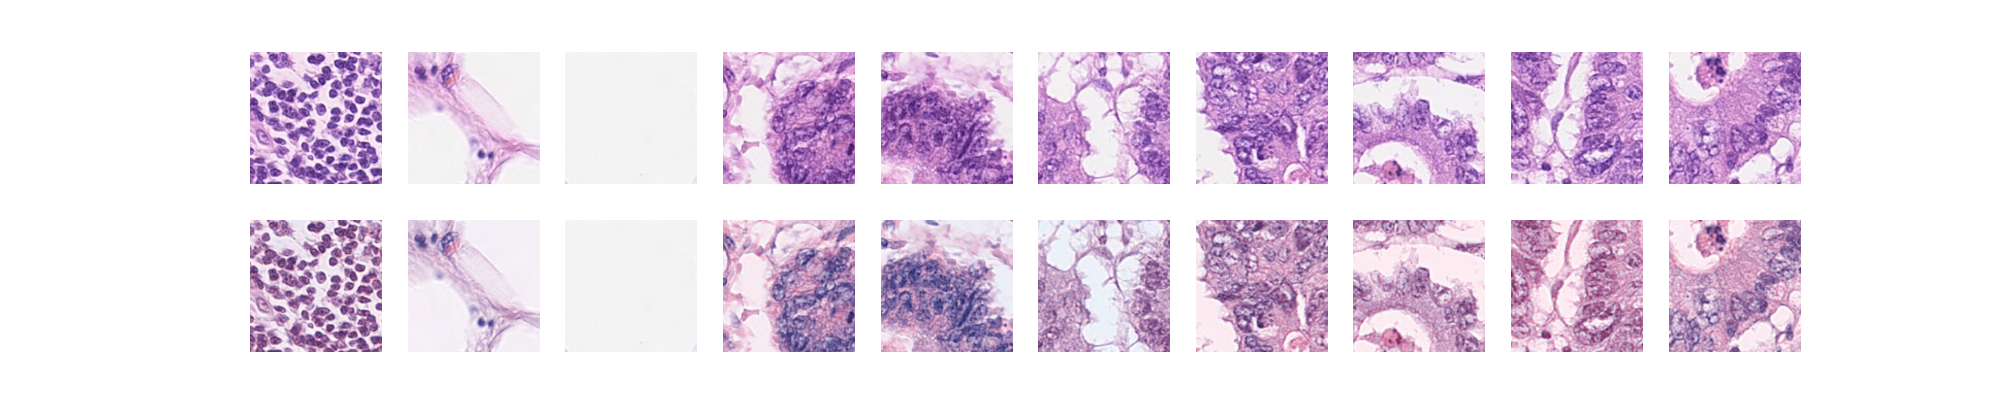

In [6]:
from src.vizualizations.image_viz import *

plot_images(np.concatenate([sample,normed],axis=0),(2,10))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
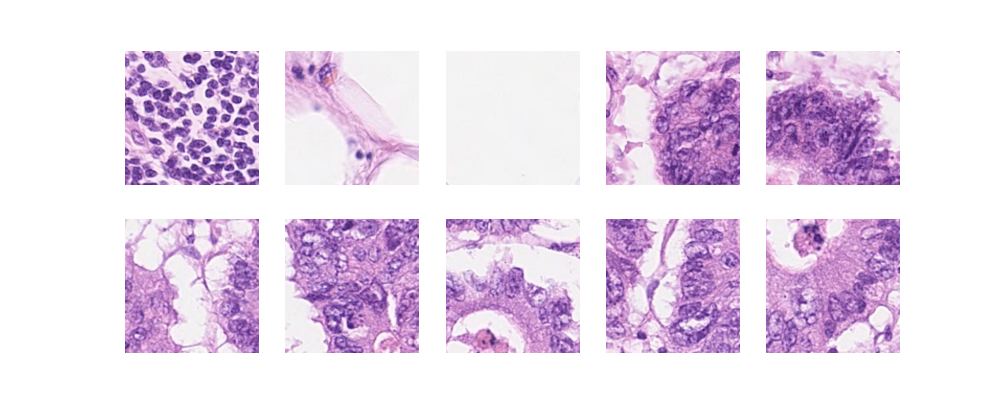

In [7]:
plot_images(images[760:770],(2,5)) # image 762 is bad


# Problems with normalizing


In [8]:
from src.transforms.image_processing.he_normalize import get_stain_vectors

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
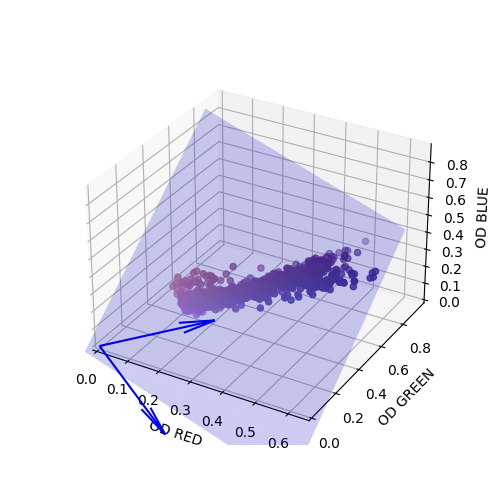

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
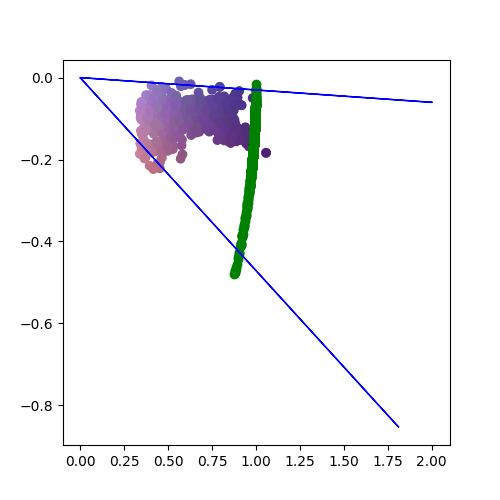

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
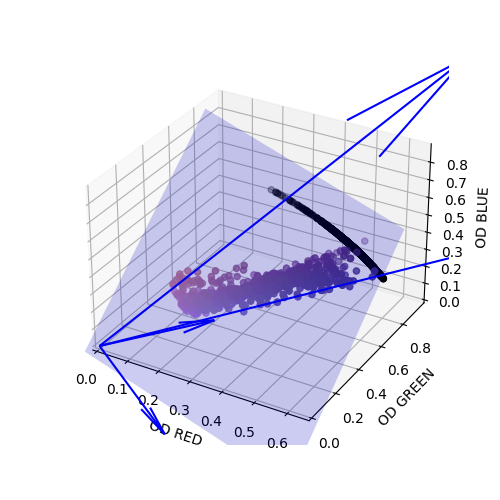

tensor([[0.6091, 0.7438, 0.2753],
        [0.2887, 0.8040, 0.5199]])

In [9]:
img = images[761]
get_stain_vectors(numpy_to_tensor(img),debug=True,beta=0.3,alpha=1)

There is a serious issue with normalizing these images. In my opinion, it is because the images are 16 times smaller than the MoNuSeg ones. There is therefore little variation as it is also so zoomed in, and we are forced to compute the vectors on what is a very narrow tube.

I therefore will not be normalizing the PanNuke dataset.

# HoVer Maps

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
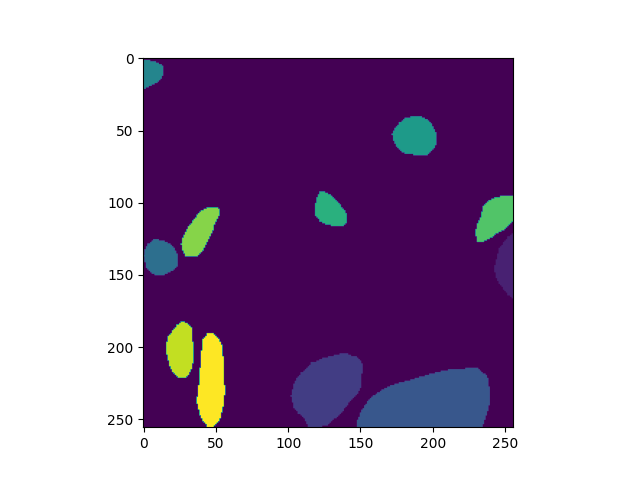

In [10]:
mask = torch.as_tensor(masks[2].astype("int16"))
plt.figure()
plt.imshow(mask)
plt.show()

In [11]:
def calculate_median_loc(arr,tot_value):
    count = 0
    for i in range(len(arr)):
        if count+arr[i]>=tot_value/2:
            return i
        count += arr[i]
    raise ("Invalid inputs")

def generate_centroid(img,nucleus_id):
    if not isinstance(img,Tensor):
        img = torch.as_tensor(img)
    mass = (img==nucleus_id)
    horiz = torch.sum(mass,dim=0).tolist()
    vert = torch.sum(mass,dim=1).tolist()
    tot_mass = torch.sum(mass).item()
    x,y = calculate_median_loc(horiz,tot_mass),calculate_median_loc(vert,tot_mass)
    return x,y

centers = torch.as_tensor([generate_centroid(mask,i) for i in range(1,10)])

In [12]:
from src.utilities.matplot_utilities import draw_bounding_box, BoundingBox

def find_bounding_box(mask:Tensor,nucleus_id):
    nucleus = mask==nucleus_id
    loc = torch.nonzero(nucleus)
    left,right = loc[:,1].min().item(),loc[:,1].max().item()
    bottom,top = loc[:,0].min().item(),loc[:,0].max().item()
    return BoundingBox(left,top,right,bottom)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
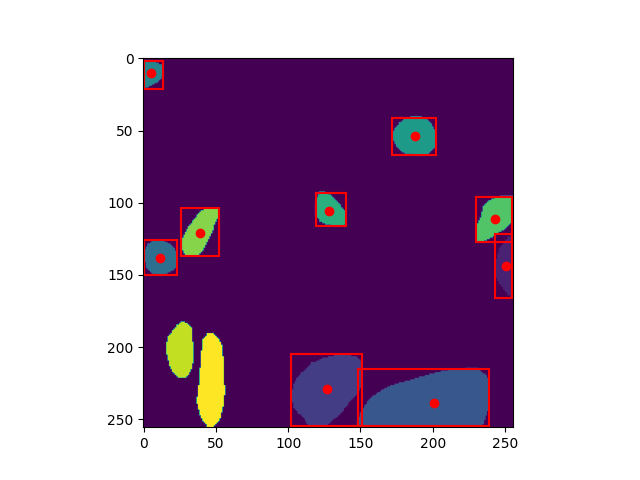

In [13]:
plt.figure()
plt.imshow(mask)
plt.scatter(centers[:,0],centers[:,1],c="red")
[draw_bounding_box(plt,find_bounding_box(mask,i)) for i in range(1,10)]
plt.show()

There may be an issue generating correct maps for the nodes on the periphery. #todo INVESTIGATE

In [14]:
def coord_loc(img):
    height,width = img.shape
    horiz,vert = torch.arange(width),torch.arange(height)
    return torch.meshgrid(horiz,vert,indexing="xy")

def hover_map(mask):
    if not isinstance(mask, Tensor):
        mask = torch.as_tensor(mask)
    nuclei = mask.max().item()
    mask = mask.float()
    h_map,v_map = torch.zeros_like(mask),torch.zeros_like(mask)
    x_coord,y_coord = coord_loc(mask)

    def norm_dist(dist_mat):
        mn,mx = torch.min(dist_mat),torch.max(dist_mat)
        return ((dist_mat-mn)/(mx-mn))*2-1
    
    for nuc_id in range(1,nuclei+1):
        cell_mask = mask.int()==nuc_id
        centre = generate_centroid(mask.int(),nuc_id)
        x_dist,y_dist = x_coord-centre[0],y_coord-centre[1]
        x_dist,y_dist = cell_mask *x_dist, cell_mask * y_dist
        x_dist,y_dist = norm_dist(x_dist),norm_dist(y_dist)
        x_dist,y_dist = cell_mask *x_dist, cell_mask * y_dist
        h_map += x_dist
        v_map += y_dist
    return torch.stack([h_map, v_map])
        
        
        

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
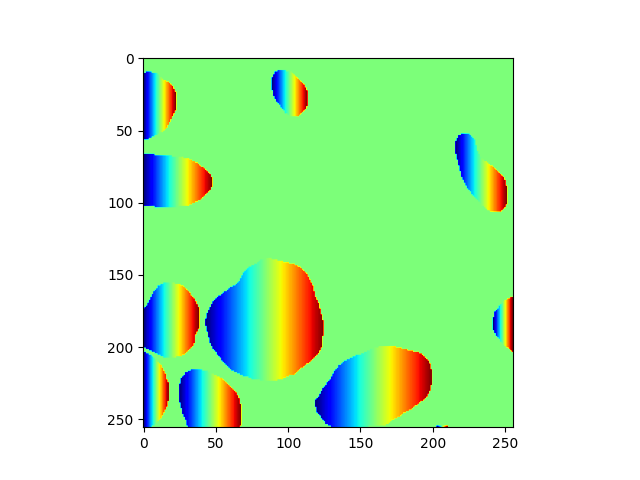

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
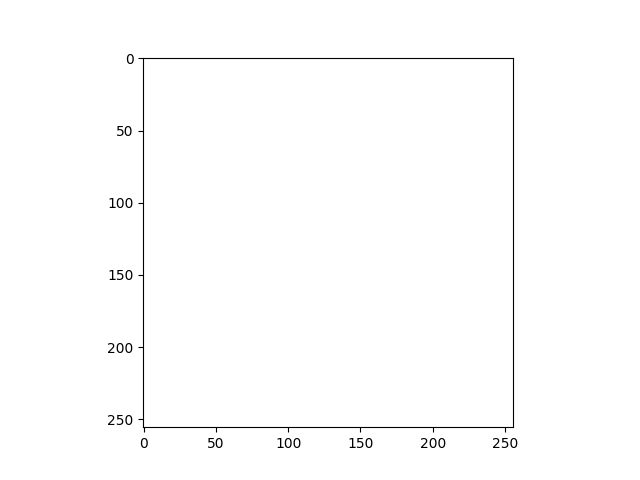

In [15]:
mask = torch.as_tensor(masks[4].astype("int16"))
maps = (hover_map(mask))
h_map,v_map = maps
print(v_map)
plt.figure()
plt.imshow(h_map,cmap="jet")
plt.show()
plt.figure()
plt.imshow(v_map,cmap="jet")
plt.show()

In [16]:
#mask = mask.numpy()
#maps = maps.numpy()
#np.save("test_pannuke_instance_mask.npy",mask)
#np.save("test_pannuke_hover_map.npy",maps)

In [17]:
#masks = np.load(os.path.join(data_folder, "masks.npy"))
#def collect_hover_maps():
#    hv_maps = [hover_map(mask.astype("int16")) for mask in tqdm(masks)]
#    hv_maps = torch.stack(hv_maps).numpy()
#    np.save(os.path.join(data_folder,"hover_maps.npy"),hv_maps)
#    
#collect_hover_maps()
    